In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import cv2
from skimage.io import imread

import sys
import os
import glob
import shutil
import argparse
from tqdm import tqdm

from albumentations import (
    convert_bbox_to_albumentations,convert_bboxes_from_albumentations
)

import albumentations as A

In [2]:
#Leemos los archivos CSV del VOC Dataset

os.chdir("/home/sergio/Documents/VOC2012")
voc_annotations = pd.read_csv("VOC_annotations.csv")
voc_metadata = pd.read_csv("VOC_metadata.csv",index_col=0)
print(voc_annotations.shape)
print(voc_metadata.shape)
display(voc_annotations.head())
display(voc_metadata.head())

(17401, 5)
(9583, 2)


,file_name,xmin,ymin,xmax,ymax
0,2008_005379.jpg,0.644000,0.002667,1.000000,1.000000
1,2012_003403.jpg,0.423567,0.559140,0.484076,0.763441
2,2009_003338.jpg,0.262000,0.451807,0.400000,1.000000
3,2009_003338.jpg,0.336000,0.460843,0.518000,1.000000
4,2009_003338.jpg,0.554000,0.367470,0.730000,1.000000


,width,height
2008_005379.jpg,500,375
2012_003403.jpg,314,186
2009_003338.jpg,500,332
2012_000625.jpg,500,333
2011_004438.jpg,500,334


In [3]:
#Leemos los archivos CSV del COCO Dataset

os.chdir("/home/sergio/Documents/COCODataset")
coco_annotations_train = pd.read_csv("COCO_annotations_train.csv", index_col=0)
coco_metadata_train = pd.read_csv("COCO_metadata_train.csv", index_col=0)

coco_annotations_val = pd.read_csv("COCO_annotations_val.csv", index_col=0)
coco_metadata_val = pd.read_csv("COCO_metadata_val.csv", index_col=0)

print(coco_annotations_train.shape)
print(coco_metadata_train.shape)
display(coco_annotations_train.head())
display(coco_metadata_train.head())

print(coco_annotations_val.shape)
print(coco_metadata_val.shape)
display(coco_annotations_val.head())
display(coco_metadata_val.head())

(262461, 5)
(64115, 2)


,file_name,xmin,ymin,xmax,ymax
0,000000262145.jpg,0.604688,0.166511,0.831250,0.920609
1,000000262145.jpg,0.772359,0.213208,0.790641,0.251054
2,000000262145.jpg,0.441203,0.203255,0.491453,0.430468
3,000000262145.jpg,0.822141,0.103372,0.963547,0.543653
4,000000262145.jpg,0.767984,0.190141,0.831203,0.390000


,width,height
000000262145.jpg,640,427
000000262146.jpg,480,640
000000524291.jpg,640,426
000000262148.jpg,640,512
000000393223.jpg,640,480


(11004, 5)
(2693, 2)


,file_name,xmin,ymin,xmax,ymax
0,000000532481.jpg,0.391906,0.394977,0.501453,0.547277
1,000000532481.jpg,0.446172,0.869859,0.465031,0.914953
2,000000458755.jpg,0.107859,0.078646,0.901687,0.986521
3,000000458755.jpg,0.885938,0.002646,1.000000,0.183604
4,000000458755.jpg,0.921906,0.191021,0.999437,0.393250


,width,height
000000532481.jpg,640,426
000000458755.jpg,640,480
000000385029.jpg,640,480
000000311303.jpg,640,427
000000393226.jpg,640,480


Juntando los CSV de VOC Dtaset y COCO Dataset

In [4]:
frames = [coco_annotations_train,voc_annotations]
annotations_train_df = pd.concat(frames)

frames = [coco_metadata_train,voc_metadata]
metadata_train_df = pd.concat(frames)

In [5]:
annotations_train_df

,file_name,xmin,ymin,xmax,ymax
0,000000262145.jpg,0.604688,0.166511,0.831250,0.920609
1,000000262145.jpg,0.772359,0.213208,0.790641,0.251054
2,000000262145.jpg,0.441203,0.203255,0.491453,0.430468
3,000000262145.jpg,0.822141,0.103372,0.963547,0.543653
4,000000262145.jpg,0.767984,0.190141,0.831203,0.390000
...,...,...,...,...,...
17396,2008_006108.jpg,0.548000,0.368000,0.906000,0.952000
17397,2010_003957.jpg,0.140000,0.138667,0.706000,0.997333
17398,2009_002569.jpg,0.340000,0.411411,0.770000,0.945946
17399,2009_002569.jpg,0.264000,0.003003,0.558000,0.426426


In [6]:
#Obtenemos el número máximo de objetos en una sola imagen
image_name = annotations_train_df.file_name.mode().values[0]
max_objects = len(annotations_train_df[annotations_train_df.file_name==image_name])

In [7]:
metadata_train_df

,width,height
000000262145.jpg,640,427
000000262146.jpg,480,640
000000524291.jpg,640,426
000000262148.jpg,640,512
000000393223.jpg,640,480
...,...,...
2008_001669.jpg,333,500
2008_006108.jpg,500,375
2010_003957.jpg,500,375
2009_002569.jpg,500,333


In [8]:
boxes = annotations_train_df[annotations_train_df.file_name =="000000262145.jpg"].iloc[:,1:].values
print(boxes)
dummy_box = [[0.4,0.4,0.5,0.5]]
ux= np.repeat(dummy_box,repeats = 20-boxes.shape[0],axis=0)
print(ux)

np.concatenate((boxes,ux),axis=0)

[[0.6046875  0.16651054 0.83125    0.9206089 ]
 [0.77235937 0.21320843 0.79064062 0.25105386]
 [0.44120312 0.20325527 0.49145312 0.43046838]
 [0.82214062 0.10337237 0.96354688 0.5436534 ]
 [0.76798437 0.19014052 0.83120313 0.39      ]
 [0.7466875  0.20562061 0.76809375 0.28384075]
 [0.48278125 0.17976581 0.56073438 0.52807963]
 [0.11245313 0.24494145 0.20540625 0.5842623 ]
 [0.55092188 0.31885246 0.59490625 0.39107728]
 [0.08153125 0.23030445 0.11573438 0.30934426]
 [0.06278125 0.22166276 0.08457812 0.27447307]
 [0.00515625 0.28400468 0.13521875 0.57562061]
 [0.23934375 0.14501171 0.4061875  0.42093677]
 [0.040625   0.1498829  0.9984375  0.44496487]]
[[0.4 0.4 0.5 0.5]
 [0.4 0.4 0.5 0.5]
 [0.4 0.4 0.5 0.5]
 [0.4 0.4 0.5 0.5]
 [0.4 0.4 0.5 0.5]
 [0.4 0.4 0.5 0.5]]


array([[0.6046875 , 0.16651054, 0.83125   , 0.9206089 ],
       [0.77235937, 0.21320843, 0.79064062, 0.25105386],
       [0.44120312, 0.20325527, 0.49145312, 0.43046838],
       [0.82214062, 0.10337237, 0.96354688, 0.5436534 ],
       [0.76798437, 0.19014052, 0.83120313, 0.39      ],
       [0.7466875 , 0.20562061, 0.76809375, 0.28384075],
       [0.48278125, 0.17976581, 0.56073438, 0.52807963],
       [0.11245313, 0.24494145, 0.20540625, 0.5842623 ],
       [0.55092188, 0.31885246, 0.59490625, 0.39107728],
       [0.08153125, 0.23030445, 0.11573438, 0.30934426],
       [0.06278125, 0.22166276, 0.08457812, 0.27447307],
       [0.00515625, 0.28400468, 0.13521875, 0.57562061],
       [0.23934375, 0.14501171, 0.4061875 , 0.42093677],
       [0.040625  , 0.1498829 , 0.9984375 , 0.44496487],
       [0.4       , 0.4       , 0.5       , 0.5       ],
       [0.4       , 0.4       , 0.5       , 0.5       ],
       [0.4       , 0.4       , 0.5       , 0.5       ],
       [0.4       , 0.4       ,

In [9]:
os.chdir("/home/sergio/TinyYOLOv3-Pedestrian-Detection")
annotations_train_df.to_csv("annotations_train_df.csv",index=False)
metadata_train_df.to_csv("metadata_train_df.csv",index=False)

## Creación de los archivos TFRecords

In [11]:
""" Create tfrecords for image data"""

class ImageTFRecordsCreator(object):
    """ 
    Class
    """
    def __init__(self, dataframe_annotations,dataframe_metadata,num_shards = 1000):
        """ 
        Constructor

        Args:
            num_shards (int): number of sharded tfrecord
        """
        self.num_shards = num_shards
        self.df_annotations = dataframe_annotations
        self.df_metadata = dataframe_metadata
        
    def _int64_feature(self, value):

        if not isinstance(value, list):
            value = [value]
        return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

    def _bytes_feature(self, value):
 
        if not isinstance(value, list):
            value = [value]
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))
    
    def _read_image_file(self,filename):

        with tf.io.gfile.GFile(filename, 'rb') as f:
            img_raw = f.read() #Lee la imagen directamente en serialized TensorfProto proto
            
        #width = self.df_metadata[self.df_metadata.file_name == filename]["width"].values
        #height = self.df_metadata[self.df_metadata.file_name == filename]["height"].values
        #depth = 3
        bboxes = self.df_annotations[self.df_annotations.file_name ==filename].iloc[:,1:].values
        dummy_box = [[0.4,0.4,0.5,0.5]]
        num_real_boxes = bboxes.shape[0]
        ux= np.repeat(dummy_box,repeats = 20-bboxes.shape[0],axis=0)
        bboxes =np.float32(np.concatenate((bboxes,ux),axis=0))
        bytes_boxes = tf.io.serialize_tensor(bboxes).numpy() #Pasa Transforms a Tensor into a serialized TensorProto proto.


        return img_raw,bytes_boxes,num_real_boxes
        

    # Convert c data to tfrecord
    def _convert_shard_data_to_tfrecord(self, input_files, output_file):
        """ Convert sharded input files to tfrecords
        """
        print('Generating %s' % output_file)
        with tf.io.TFRecordWriter(output_file) as record_writer:
            for input_file in input_files:
                img_raw,bytes_boxes,num_real_boxes= self._read_image_file(input_file) 
                feature={
                        'bboxes': self._bytes_feature(bytes_boxes),
                        'image_raw': self._bytes_feature(tf.compat.as_bytes(img_raw)),
                        'num_real_boxes':self._int64_feature(num_real_boxes)
                        }
                example = tf.train.Example(features=tf.train.Features(feature=feature))
                record_writer.write(example.SerializeToString())

    # Convert data to tfrecord
    def _convert_data_to_tfrecord(self, input_files, output_dir):
        """ convert input image files to tfrecords
          Args:
            input_files (list): List of input images to be converted to tfr
            output_dir (str): Output folder where created tfr files will be kept
          Description:
            Shard input_files if they are above threshold and create those many tfr
        """
        num_input_files = len(input_files)
        for i in tqdm(range(0, num_input_files, self.num_shards)):
            sharded_input_files = input_files[i:i+self.num_shards]
            tfr_file_name = os.path.join(output_dir, 'tfr_'+str(i))
            self._convert_shard_data_to_tfrecord(sharded_input_files, tfr_file_name)

In [12]:
os.chdir("/home/sergio/Documents/pedestrian_dataset_train")

In [13]:
input_files = metadata_train_df.index.values
tfrecords_outdir = "/home/sergio/Documents/pedestrian_dataset_train_tfr"
num_shards = 1000
tfr_creator = ImageTFRecordsCreator(annotations_train_df,metadata_train_df,num_shards=num_shards)
tfr_creator._convert_data_to_tfrecord(input_files, tfrecords_outdir)

  0%|          | 0/74 [00:00<?, ?it/s]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_0


  1%|▏         | 1/74 [00:08<10:47,  8.87s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_1000


  3%|▎         | 2/74 [00:17<10:26,  8.69s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_2000


  4%|▍         | 3/74 [00:25<10:10,  8.59s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_3000


  5%|▌         | 4/74 [00:33<09:56,  8.52s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_4000


  7%|▋         | 5/74 [00:42<09:42,  8.44s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_5000


  8%|▊         | 6/74 [00:50<09:30,  8.38s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_6000


  9%|▉         | 7/74 [00:58<09:20,  8.36s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_7000


 11%|█         | 8/74 [01:06<09:11,  8.35s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_8000


 12%|█▏        | 9/74 [01:15<09:02,  8.34s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_9000


 14%|█▎        | 10/74 [01:23<08:53,  8.33s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_10000


 15%|█▍        | 11/74 [01:31<08:45,  8.34s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_11000


 16%|█▌        | 12/74 [01:40<08:37,  8.35s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_12000


 18%|█▊        | 13/74 [01:48<08:28,  8.34s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_13000


 19%|█▉        | 14/74 [01:57<08:21,  8.36s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_14000


 20%|██        | 15/74 [02:05<08:12,  8.35s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_15000


 22%|██▏       | 16/74 [02:13<08:04,  8.34s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_16000


 23%|██▎       | 17/74 [02:22<07:55,  8.34s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_17000


 24%|██▍       | 18/74 [02:30<07:47,  8.34s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_18000


 26%|██▌       | 19/74 [02:38<07:38,  8.34s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_19000


 27%|██▋       | 20/74 [02:47<07:29,  8.33s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_20000


 28%|██▊       | 21/74 [02:55<07:22,  8.35s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_21000


 30%|██▉       | 22/74 [03:03<07:14,  8.35s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_22000


 31%|███       | 23/74 [03:12<07:05,  8.35s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_23000


 32%|███▏      | 24/74 [03:20<06:58,  8.37s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_24000


 34%|███▍      | 25/74 [03:28<06:49,  8.36s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_25000


 35%|███▌      | 26/74 [03:37<06:41,  8.37s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_26000


 36%|███▋      | 27/74 [03:45<06:33,  8.37s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_27000


 38%|███▊      | 28/74 [03:53<06:24,  8.36s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_28000


 39%|███▉      | 29/74 [04:02<06:16,  8.37s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_29000


 41%|████      | 30/74 [04:10<06:07,  8.36s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_30000


 42%|████▏     | 31/74 [04:19<05:58,  8.35s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_31000


 43%|████▎     | 32/74 [04:27<05:50,  8.34s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_32000


 45%|████▍     | 33/74 [04:35<05:41,  8.33s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_33000


 46%|████▌     | 34/74 [04:44<05:33,  8.34s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_34000


 47%|████▋     | 35/74 [04:52<05:25,  8.35s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_35000


 49%|████▊     | 36/74 [05:00<05:17,  8.37s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_36000


 50%|█████     | 37/74 [05:09<05:10,  8.40s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_37000


 51%|█████▏    | 38/74 [05:17<05:01,  8.39s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_38000


 53%|█████▎    | 39/74 [05:25<04:52,  8.37s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_39000


 54%|█████▍    | 40/74 [05:34<04:44,  8.36s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_40000


 55%|█████▌    | 41/74 [05:42<04:35,  8.36s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_41000


 57%|█████▋    | 42/74 [05:51<04:27,  8.36s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_42000


 58%|█████▊    | 43/74 [05:59<04:18,  8.35s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_43000


 59%|█████▉    | 44/74 [06:07<04:10,  8.34s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_44000


 61%|██████    | 45/74 [06:16<04:01,  8.34s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_45000


 62%|██████▏   | 46/74 [06:24<03:53,  8.35s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_46000


 64%|██████▎   | 47/74 [06:32<03:45,  8.34s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_47000


 65%|██████▍   | 48/74 [06:41<03:36,  8.34s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_48000


 66%|██████▌   | 49/74 [06:49<03:28,  8.33s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_49000


 68%|██████▊   | 50/74 [06:57<03:20,  8.34s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_50000


 69%|██████▉   | 51/74 [07:06<03:11,  8.33s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_51000


 70%|███████   | 52/74 [07:14<03:03,  8.35s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_52000


 72%|███████▏  | 53/74 [07:22<02:55,  8.34s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_53000


 73%|███████▎  | 54/74 [07:31<02:46,  8.35s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_54000


 74%|███████▍  | 55/74 [07:39<02:38,  8.34s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_55000


 76%|███████▌  | 56/74 [07:47<02:29,  8.33s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_56000


 77%|███████▋  | 57/74 [07:56<02:21,  8.33s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_57000


 78%|███████▊  | 58/74 [08:04<02:13,  8.34s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_58000


 80%|███████▉  | 59/74 [08:12<02:05,  8.35s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_59000


 81%|████████  | 60/74 [08:21<01:56,  8.35s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_60000


 82%|████████▏ | 61/74 [08:29<01:48,  8.36s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_61000


 84%|████████▍ | 62/74 [08:37<01:40,  8.35s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_62000


 85%|████████▌ | 63/74 [08:46<01:31,  8.35s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_63000


 86%|████████▋ | 64/74 [08:54<01:23,  8.35s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_64000


 88%|████████▊ | 65/74 [09:02<01:13,  8.14s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_65000


 89%|████████▉ | 66/74 [09:09<01:03,  7.97s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_66000


 91%|█████████ | 67/74 [09:17<00:54,  7.85s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_67000


 92%|█████████▏| 68/74 [09:24<00:46,  7.77s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_68000


 93%|█████████▎| 69/74 [09:32<00:38,  7.70s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_69000


 95%|█████████▍| 70/74 [09:40<00:30,  7.67s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_70000


 96%|█████████▌| 71/74 [09:47<00:22,  7.64s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_71000


 97%|█████████▋| 72/74 [09:55<00:15,  7.62s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_72000


 99%|█████████▊| 73/74 [10:02<00:07,  7.60s/it]

Generating /home/sergio/Documents/pedestrian_dataset_train_tfr/tfr_73000


100%|██████████| 74/74 [10:08<00:00,  8.22s/it]


## Lectura de los TFRecords

In [16]:
import tensorflow as tf
import os
import time

In [17]:
image_feature_description = {
    'bboxes': tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'num_real_boxes':tf.io.FixedLenFeature([], tf.int64),
}

In [18]:
def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

#def _parse_image_function(example_proto_list):
#  # Parse the input tf.Example proto using the dictionary above.
#  return tf.io.parse_single_example(example_proto, image_feature_description)

def read_tfr_dataset(tf_records_list_names):
    num_images=0
    raw_image_dataset = tf.data.TFRecordDataset(tf_records_list_names)
    parsed_image_dataset = raw_image_dataset.map(_parse_image_function)

    for image_features in parsed_image_dataset:
        
        bboxes =  tf.io.parse_tensor(image_features['bboxes'], out_type=tf.float64)
        image = tf.image.decode_jpeg(image_features['image_raw'],channels = 3)
        num_real_boxes = image_features['num_real_boxes']
        

    return None

In [19]:
def preprocessing(image_features):
    bboxes =  tf.io.parse_tensor(image_features['bboxes'], out_type=tf.float32)
    image = tf.image.decode_jpeg(image_features['image_raw'],channels = 3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(tf.cast(image, tf.float32),size=(416,416))
    num_real_boxes = image_features['num_real_boxes']
    return image,bboxes,num_real_boxes

In [20]:
os.chdir("/home/sergio/Documents/pedestrian_dataset_train_tfr")
filenames = os. listdir()
raw_image_dataset = tf.data.TFRecordDataset(filenames)
parsed_image_dataset = raw_image_dataset.map(_parse_image_function).map(preprocessing,num_parallel_calls=8)

In [21]:
count = 0
inicio = time.time()
for i in parsed_image_dataset.batch(8):
    count+=1
fin = time.time()
print(fin-inicio)
print(count)

53.28766989707947
9213


In [22]:
len(i)

3

In [24]:
i[1]

<tf.Tensor: shape=(2, 20, 4), dtype=float32, numpy=
array([[[0.46441665, 0.36776564, 0.668375  , 0.65540624],
        [0.3905    , 0.40528125, 0.4794375 , 0.53870314],
        [0.4       , 0.4       , 0.5       , 0.5       ],
        [0.4       , 0.4       , 0.5       , 0.5       ],
        [0.4       , 0.4       , 0.5       , 0.5       ],
        [0.4       , 0.4       , 0.5       , 0.5       ],
        [0.4       , 0.4       , 0.5       , 0.5       ],
        [0.4       , 0.4       , 0.5       , 0.5       ],
        [0.4       , 0.4       , 0.5       , 0.5       ],
        [0.4       , 0.4       , 0.5       , 0.5       ],
        [0.4       , 0.4       , 0.5       , 0.5       ],
        [0.4       , 0.4       , 0.5       , 0.5       ],
        [0.4       , 0.4       , 0.5       , 0.5       ],
        [0.4       , 0.4       , 0.5       , 0.5       ],
        [0.4       , 0.4       , 0.5       , 0.5       ],
        [0.4       , 0.4       , 0.5       , 0.5       ],
        [0.4       ,

In [68]:
os.chdir("/home/sergio/Documents/VOC2012/pedestrian_dataset_voc_tfr")
filenames = os. listdir()

In [53]:
import time
inicio = time.time()
read_tfr_dataset(filenames)
fin = time.time()

print(fin-inicio)

17.129613161087036


In [68]:
#%timeit read_tfr_dataset(filenames)

26.2 s ± 713 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [69]:
os.chdir("/home/sergio/Documents/VOC2012/pedestrian_dataset_voc")
filenames = os. listdir()

In [70]:
from skimage.io import imread

def read_dataset(file_names):
    num_images = 0
    for i in filenames:
        #print(i)
        aux = imread(i)
        num_images +=1
    #print(num_images)
    return None

In [71]:
%timeit read_dataset(filenames)

28.8 s ± 153 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Data Agumentation

In [41]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
dataset = tf.data.Dataset.from_tensor_slices((x_train[0:32] / 255).astype(np.float32))

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

def plot_images(dataset, n_images, samples_per_image):
    output = np.zeros((32 * n_images, 32 * samples_per_image, 3))

    row = 0
    for images in dataset.repeat(samples_per_image).batch(n_images):
        output[:, row*32:(row+1)*32] = np.vstack(images.numpy())
        row += 1

    plt.figure()
    plt.imshow(output)
    plt.show()

In [43]:
def rotate(x: tf.Tensor) -> tf.Tensor:
    """Rotation augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))


In [44]:
def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x

In [45]:
def color(x: tf.Tensor) -> tf.Tensor:
    """Color augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

In [46]:
def zoom(x: tf.Tensor) -> tf.Tensor:
    """Zoom augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_ind=np.zeros(len(scales)), crop_size=(32, 32))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))

0.0025637149810791016


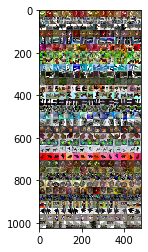

In [48]:
augmentations = [flip, color, rotate]

# Add the augmentations to the dataset
for f in augmentations:
    # Apply the augmentation, run 4 jobs in parallel.
    dataset = dataset.map(f, num_parallel_calls=1)

# Make sure that the values are still in [0, 1]
inicio = time.time()
dataset = dataset.map(lambda x: tf.clip_by_value(x, 0, 1), num_parallel_calls=4)
fin = time.time()

print(fin-inicio)
plot_images(dataset, n_images=32, samples_per_image=15)

In [1]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)
import numpy as np

def strong_aug(p=0.5):
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=0.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=p)

image = np.ones((300, 300, 3), dtype=np.uint8)
mask = np.ones((300, 300), dtype=np.uint8)
whatever_data = "my name"
augmentation = strong_aug(p=0.9)
data = {"image": image, "mask": mask, "whatever_data": whatever_data, "additional": "hello"}
augmented = augmentation(**data)
image, mask, whatever_data, additional = augmented["image"], augmented["mask"], augmented["whatever_data"], augmented["additional"]

In [3]:
augmentation

In [5]:
type(augmented)

dict

In [6]:
augmented.keys()

dict_keys(['image', 'mask', 'whatever_data', 'additional'])